# Watershared 

In [4]:
import pycuda.autoinit
import pycuda.driver as cu
from pycuda import gpuarray
from pycuda.reduction import ReductionKernel
from pycuda.elementwise import ElementwiseKernel
import time
import numpy as np
from pycuda.compiler import SourceModule
import string
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import  animation
import pycuda.compiler as nvcc
import pycuda.gpuarray as gpu

In [10]:
src = cv2.imread('../../datas/f3.jpg')
rgb = cv2.cvtColor(src,cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(src,cv2.COLOR_RGB2GRAY)

In [3]:
def load_kernel_from_file(fname,kname):
    sources = None
    kernel = None
    with open(fname,encoding='utf-8') as f:
        sources = f.read() # 通过str函数转换为unicode编码
        sm = SourceModule(str(sources))
        kernel = sm.get_function(kname)
    return kernel

def load_kernel_from_string(sources,kname):
    sm = SourceModule(str(sources))
    kernel = sm.get_function(kname)
    return kernel

In [6]:
kernel_source = open("../../datas/cuda/33-watershared.cu").read()
main_module = nvcc.SourceModule(kernel_source)
descent_kernel = main_module.get_function("descent_kernel")
image_texture = main_module.get_texref("img")
plateau_kernel = main_module.get_function("plateau_kernel")
minima_kernel = main_module.get_function("minima_kernel")
flood_kernel = main_module.get_function("flood_kernel")
increment_kernel = main_module.get_function("increment_kernel")


In [13]:
# PyCUDA wrapper for watershed.
def watershed(I):

  # Get contiguous image + shape.
    height, width = I.shape
    I = np.float32(I.copy())

    # Get block/grid size for steps 1-3.
    block_size =  (6,6,1)
    grid_size =   (width//(block_size[0]-2),
                height//(block_size[0]-2))

    # Get block/grid size for step 4.
    block_size2 = (16,16,1)
    grid_size2  = (width//(block_size2[0]-2),
                height//(block_size2[0]-2))

    # Initialize variables.
    labeled       = np.zeros([height,width]) 
    labeled       = np.float32(labeled)
    width         = np.int32(width)
    height        = np.int32(height)
    count         = np.int32([0])

    # Transfer labels asynchronously.
    labeled_d = gpu.to_gpu_async(labeled)
    counter_d = gpu.to_gpu_async(count)

    # Bind CUDA textures.
    I_cu = cu.matrix_to_array(I, order='C')
    cu.bind_array_to_texref(I_cu, image_texture)

    # Step 1.
    descent_kernel(labeled_d, width, 
    height, block=block_size, grid=grid_size)
  
    start_time = cu.Event()
    end_time = cu.Event()
    start_time.record()

    # Step 2.
    increment_kernel(labeled_d,width,height,
    block=block_size2,grid=grid_size2)
    counters_d = gpu.to_gpu(np.int32([0]))
    old, new = -1, -2

    while old != new:
        old = new
        minima_kernel(labeled_d, counters_d,
        width, height, block=block_size, grid=grid_size)
        new = counters_d.get()[0]

    # Step 3.
    counters_d = gpu.to_gpu(np.int32([0]))
    old, new = -1, -2
    while old != new:
        old = new
        plateau_kernel(labeled_d, counters_d, width,
        height, block=block_size, grid=grid_size)
        new = counters_d.get()[0]
  
    # Step 4
    counters_d = gpu.to_gpu(np.int32([0]))
    old, new = -1, -2
    while old != new:
        old = new
        flood_kernel(labeled_d, counters_d, width,
        height, block=block_size2, grid=grid_size2)
        new = counters_d.get()[0]

    result = labeled_d.get()
  
    # End GPU timers.
    end_time.record()
    end_time.synchronize()
    gpu_time = start_time.\
    time_till(end_time) * 1e-3

    # print str(gpu_time)

    return result

In [18]:
dst = watershed(np.float32(gray)/255.)

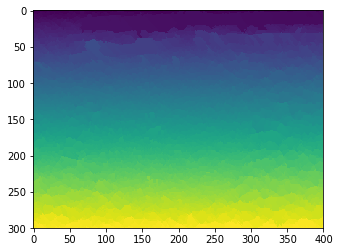

In [20]:
plt.imshow(dst)

In [22]:
print(dst)

[[   401.    404.    404. ...   3200.   1200.   1200.]
 [   401.    404.    404. ...   3200.   3200.   1200.]
 [   404.    404.    404. ...   3200.   3200.   1200.]
 ...
 [118804. 118804. 118804. ... 116800. 118800. 118800.]
 [118804. 118804. 118804. ... 118800. 118800. 118800.]
 [118804. 118804. 118804. ... 118800. 118800. 120000.]]


In [21]:
print(dst.dtype)

float32
